In [1]:
using Pkg
Pkg.activate("/Users/ryansenne/Documents/GitHub/SSM")

include("/Users/ryansenne/Documents/Github/SSM//src/SSM.jl")
using .SSM
using LinearAlgebra
using Random
using Distributions
using Plots

  Activating project at `\Users\ryansenne\Documents\GitHub\SSM`


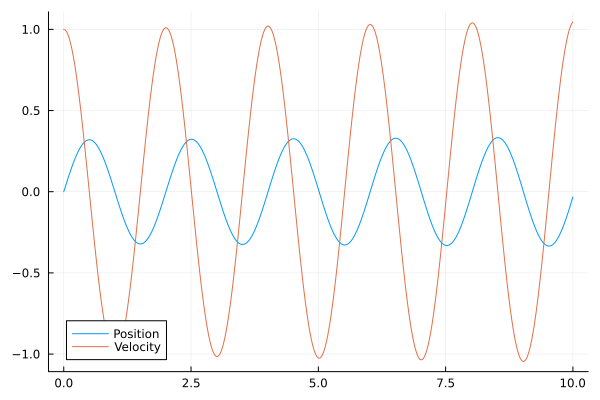

In [2]:
# Generate data from a known linear dynamical system--a pendulum
g = 9.81 # gravity
l = 1.0 # length of pendulum
dt = 0.001 # time step
T = 10.0 # total time
# Discrete-time dynamics
A = [1.0 dt; -g/l*dt 1.0]
# Initial state
x0 = [0.0; 1.0]
# Time vector
t = 0:dt:T
# Generate data
x = zeros(2, length(t))
x[:,1] = x0
for i = 2:length(t)
    x[:,i] = A*x[:,i-1]
end
# Plot data 
plot(t, x[1,:], label="Position")
plot!(t, x[2,:], label="Velocity")

In [5]:
# Now lets add noise to the system and see if we can recover the dynamics
# Add driving Gaussian noise to simulate observations
x_noisy = zeros(2, length(t))
x_noisy[:, 1] = x0
observation_noise_std = 0.5

noise = rand(Normal(0, observation_noise_std), (2, length(t)))

for i in 2:length(t)
    x_noisy[:, i] = A * x[:, i-1] + noise[:, i]
end

# Define the LDS model parameters
H = I(2)  # Observation matrix (assuming direct observation)
Q = 0.00001 * I(2)  # Process noise covariance
R = (observation_noise_std^2) * I(2)  # Observation noise covariance
P0 = 0.1*I(2)  # Initial state covariance
x0 = [0.0; 1.0]  # Initial state mean

# Create the Kalman filter parameter vector
kf = LDS(A, Matrix{Float64}(H), nothing, Matrix{Float64}(Q), Matrix{Float64}(R), x0, Matrix{Float64}(P0), nothing, 2, 2, "Gaussian", Vector([true, true, false, true, true, true, true, false]))

# Run the Kalman filter
x_pred, P, v, F, K = KalmanFilter(kf, Matrix{Float64}(x_noisy'))

# Run the smoother
x_smooth, P_smooth = KalmanSmoother(kf, Matrix{Float64}(x_noisy'))

([0.0 1.0; -0.011717249625361172 1.3069224278822187; … ; -0.04832113739285315 1.082234213790131; -0.04429661267861276 1.0795842123263306], [0.1 0.0; 0.0714325930326271 -0.00044945447319703067; … ; 0.0012809778222691841 -0.0007007835122796919; 0.0012809778222691841 -0.0007007835122796919;;; 0.0 0.1; -0.0004494544731970308 0.07143745163548235; … ; -0.0007007835122796922 0.0023268745448765025; -0.0007007835122796922 0.0023268745448765025])

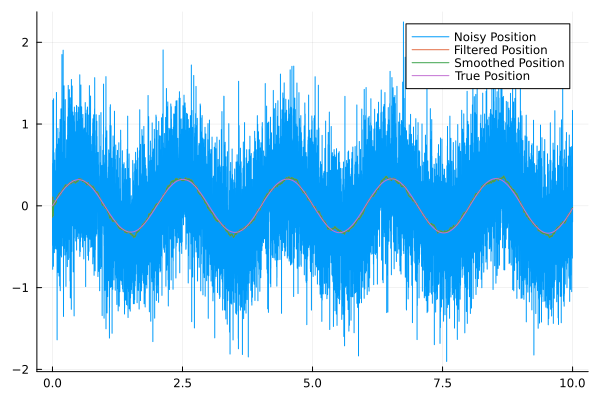

In [4]:
# plot the results
plot(t, x_noisy[1, :], label="Noisy Position")
plot!(t, x_pred[:, 1], label="Filtered Position")
plot!(t, x_smooth[:, 1], label="Smoothed Position")
plot!(t, x[1, :], label="True Position")


In [3]:
# now create a Kalman Filter where we want to learn the parameters

kf_unknown = LDS(; obs_dim=2, latent_dim=2, emissions="Gaussian", fit_bool=[true, true, false, true, true, true, true])

# KalmanFilterOptim!(kf_unknown, x_noisy')

# x_smooth_unknown, P_smooth_unknown = KalmanSmoother(kf_unknown, Matrix{Float64}(x_noisy'))

LDS([0.9114511747950196 0.7535721542561012; 0.594147603400121 0.7939783618844056], [0.18984086223541485 0.6418127550061964; 0.7767343706272521 0.7717407785384662], nothing, Bool[1 0; 0 1], Bool[1 0; 0 1], [0.7262028112444315, 0.637859812112413], [0.7650559771902218 0.9067272337340138; 0.6740367815874031 0.5529807927195236], nothing, 2, 2, "Gaussian", Bool[1, 1, 0, 1, 1, 1, 1])

In [6]:
SSM.KalmanFilterEM!(kf_unknown, Matrix{Float64}(x_noisy'), 100)

ErrorException: adjoint not defined for Array{Float64, 3}. Consider using `permutedims` for higher-dimensional arrays.

In [7]:
KalmanFilterOptim!(kf_unknown, x_noisy')


22-element Vector{Float64}:
 0.255654205085044
 0.38445300900963575
 0.08350689070112027
 0.39642473040723303
 0.4653290415131661
 0.2694943088605577
 0.42242733223313544
 0.25199277468265435
 1.0
 0.0
 ⋮
 0.0
 0.0
 1.0
 0.19979153749733825
 0.5284986136130939
 0.21447106810107364
 0.6322931928532753
 0.40468365037156817
 0.38562399619520993

In [7]:
SSM.loglikelihood(kf_unknown, Matrix{Float64}(x_noisy'))

-22233.11173992924

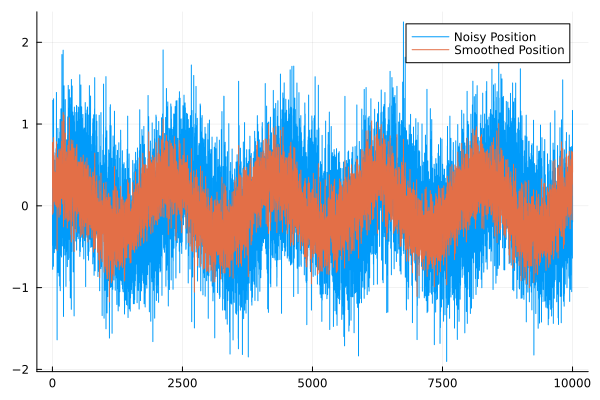

In [8]:
plot(x_noisy[1, :], label="Noisy Position")
plot!(x_smooth_unknown[:, 1], label="Smoothed Position")

In [9]:
SSM.KalmanFilterEM!(kf_unknown, Matrix{Float64}(x_noisy'))

ErrorException: adjoint not defined for Array{Float64, 3}. Consider using `permutedims` for higher-dimensional arrays.